In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm


import sys

sys.path.append("../utils")
from utils import *

In [2]:
combined_df = retrieve_data()
combined_df

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
0,2023-10-25,237.55,17.6858,107.00,33.0793,426.4,15.7900,1.4594
1,2023-10-26,237.25,17.9504,104.45,33.5406,426.8,15.9736,1.4508
2,2023-10-27,237.75,19.6028,104.40,33.4355,424.4,16.3945,1.4478
3,2023-10-30,241.30,19.3503,104.75,33.1531,428.2,15.9477,1.4623
4,2023-10-31,233.85,19.2518,106.90,32.7788,430.6,15.7948,1.4489
...,...,...,...,...,...,...,...,...
248,2024-10-21,272.90,17.7575,126.65,31.1486,526.2,14.1699,0.6532
249,2024-10-22,272.20,18.2963,126.95,30.9890,520.4,14.7228,0.6544
250,2024-10-23,277.20,17.6974,126.05,31.3139,519.6,14.0134,0.6448
251,2024-10-24,279.80,17.7883,128.45,31.6005,520.6,14.4540,0.6213


In [3]:
combined_df = retrieve_data()
np.random.seed(42)
n_days = 252
dt = 1 / n_days
close = combined_df[["ROG_Last_Price", "CFR_Last_Price", "ZURN_Last_Price"]]
tickers = close.columns
log_returns = np.log((close / close.shift(1)).dropna())

# Heston Stochastic Volatility Model 

only use constant interest rate r + does not incorporate option prices into the calibration process.

!!! calibrate based solely on historical stock price data, particularly the realized volatility of returns.

options data need to be collect more on daily basis from 2024/25/07 to 024/25/10.
i only collected on quaterly basis so now cannot right

In [4]:
vol = log_returns.rolling(window=30).var() * n_days
vol

,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
...,...,...,...
248,0.020141,0.118830,0.008371
249,0.019935,0.118104,0.009412
250,0.022582,0.118542,0.009246
251,0.018368,0.120691,0.009082


In [5]:
vol.mean()

ROG_Last_Price     0.040053
CFR_Last_Price     0.080205
ZURN_Last_Price    0.019759
dtype: float64

In [6]:
vol.iloc[0]

ROG_Last_Price    NaN
CFR_Last_Price    NaN
ZURN_Last_Price   NaN
Name: 1, dtype: float64

In [7]:
def objective(x):
    a = x**2 - 1
    return a

In [8]:
bounds = [
    (0.1, 10.0),  # kappa
    (0.001, 0.5),  # theta
    (0.01, 1.0),  # sigma
    (-0.99, 0.99),
]  # rho

result = minimize(objective, x0=[100], bounds=[(-np.inf, np.inf)], method="L-BFGS-B")

In [9]:
result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.0
        x: [-2.149e-09]
      nit: 3
      jac: [ 1.110e-08]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [10]:
sys.path.append("./linh")
from option import *

In [11]:
import os

In [12]:
files = ["rog_call.csv", "cfr_call.csv", "zurn_call.csv"]

In [13]:
input_directory = "../data/option_data/"

In [14]:
options = pd.DataFrame(
    columns=["maturity", "strike", "price", "IV", "day", "month", "year", "product"]
)
for i, f in enumerate(files):
    for file in next(os.walk(input_directory + "cleaned"))[1]:
        data = pd.read_csv(f"../data/option_data/cleaned/{file}/" + f)
        data["day"] = file[:2]
        data["month"] = file[2:4]
        data["year"] = file[4:]
        data["product"] = tickers[i]
        options = pd.concat([options, data])

/tmp/ipykernel_172443/1657585005.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  options = pd.concat([options, data])


In [15]:
options = options.sort_values(["product", "month", "day", "maturity"])

In [16]:
options

,maturity,strike,price,IV,day,month,year,product
0,0.156057,124,9.674999,24.402237,25,07,2024,CFR_Last_Price
1,0.156057,126,8.200000,23.955641,25,07,2024,CFR_Last_Price
2,0.156057,128,6.850000,23.466326,25,07,2024,CFR_Last_Price
3,0.156057,130,5.600000,22.889894,25,07,2024,CFR_Last_Price
4,0.156057,132,4.515000,22.497936,25,07,2024,CFR_Last_Price
...,...,...,...,...,...,...,...,...
49,0.229979,520,13.550000,14.122618,25,10,2024,ZURN_Last_Price
50,0.229979,540,5.600000,13.379794,25,10,2024,ZURN_Last_Price
51,0.229979,560,1.720000,12.748696,25,10,2024,ZURN_Last_Price
52,0.229979,580,1.505000,16.218067,25,10,2024,ZURN_Last_Price


In [17]:
from lmfit import Parameters, minimize

In [18]:
options[options["product"] == "CFR_Last_Price"]

,maturity,strike,price,IV,day,month,year,product
0,0.156057,124,9.674999,24.402237,25,07,2024,CFR_Last_Price
1,0.156057,126,8.200000,23.955641,25,07,2024,CFR_Last_Price
2,0.156057,128,6.850000,23.466326,25,07,2024,CFR_Last_Price
3,0.156057,130,5.600000,22.889894,25,07,2024,CFR_Last_Price
4,0.156057,132,4.515000,22.497936,25,07,2024,CFR_Last_Price
...,...,...,...,...,...,...,...,...
43,0.229979,130,7.125000,30.834446,25,10,2024,CFR_Last_Price
44,0.229979,135,5.060000,30.493761,25,10,2024,CFR_Last_Price
45,0.229979,140,3.480000,30.214775,25,10,2024,CFR_Last_Price
46,0.229979,145,2.350000,30.146441,25,10,2024,CFR_Last_Price


In [19]:
combined_df.iloc[0]["Date"].strftime("%Y-%m-%d")

'2023-10-25'

In [71]:
import numpy as np
import pandas as pd
from tqdm import tqdm


class HestonModelCalibration:
    def __init__(self, current_id, data, n_days=252):
        self.current_id = current_id
        self.data = data
        self.n_days = n_days
        self.dt = 1 / n_days
        self.tickers = data.columns
        self.log_returns = np.log((data / data.shift(1)).dropna())

    def calculate_realized_vol(self, window_size=30):
        """Calculate realized volatility for initial variance"""
        return self.log_returns.rolling(window=window_size).var() * self.n_days

    def estimate_correlation_matrix(self, window_size=30):
        """Estimate correlation matrix from historical data"""
        return self.log_returns.iloc[-window_size:].corr().values

    def func_heston(
        self,
        u,
        St,
        K,
        r,
        T,
        sigma,
        kappa,
        theta,
        v0,
        rho,
    ):

        # logger_yq.info(f"Final result: {result}")
        # b1 = kappa + lambda_ - rho * sigma * r
        # b2 = kappa + lambda_
        # prod = rho * sigma * 1j * u
        # d1 = np.sqrt((prod - b1)**2 - sigma ** 2 * (1j * r - (1j)**2))
        # d2 = np.sqrt((prod - b2)**2 + sigma ** 2 * (1j * r - (1j)**2))
        # g1 = (b1 - prod + d1) / (b1 - prod - d1)
        # g2 = (b2 - prod + d2) / (b2 - prod - d2)

        # lambda_ = 0
        # b1 = kappa + lambda_ - rho * sigma * r
        # b2 = kappa + lambda_
        # prod = rho * sigma * u * 1j
        # d1 = np.sqrt((prod - b1)**2 - sigma ** 2 * (1j * u - (1j)**2))
        # d2 = np.sqrt((prod - b2)**2 + sigma ** 2 * (1j * u - (1j)**2))
        # g1 = (b1 - prod + d1) / (b1 - prod - d1)
        # g2 = (b2 - prod + d2) / (b2 - prod - d2)

        # d1 = (b1 - prod + d1) / (sigma ** 2) * (1 - g1 * np.exp(d1 * T)) / (1 - g1)
        # d2 = (b2 - prod + d2) / (sigma ** 2) * (1 - g2 * np.exp(d2 * T)) / (1 - g2)

        # c1 = r * 1j * u * T + kappa * theta / (sigma ** 2) * (b1 - prod + d1) * T - 2 * np.log((1 - g1 * np.exp(d1 * T)) / (1 - g1))
        # c2 = r * 1j * u * T + kappa * theta / (sigma ** 2) * (b2 - prod + d2) * T - 2 * np.log((1 - g2 * np.exp(d2 * T)) / (1 - g2))

        # D1 = (b1 - prod + d1) / (sigma ** 2) * (1 - g1 * np.exp(d1 * T)) / (1 - g1)
        # D2 = (b2 - prod + d2) / (sigma ** 2) * (1 - g2 * np.exp(d2 * T)) / (1 - g2)

        # res1 = St ** (u * 1j) * np.exp(c1 + D1 * v0)
        # res2 = St ** (u * 1j) * np.exp(c2 + D2 * v0)
        # return res1, res2
        ## ASSUME LAMBDA IS 0
        xi = kappa - rho * sigma * 1j * u
        d = np.sqrt((rho * sigma * 1j * u - xi)**2 - sigma**2 * (-u * 1j - u**2))
        g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
        C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
        D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
        return np.exp(C + D * v0 + 1j * u * np.log(St))

    def price_heston_mid(self, St, K, r, T, sigma, kappa, theta, v0, rho):

        from scipy.integrate import quad_vec

        integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * self.func_heston(u - 1j, St, K, r, T, kappa, theta, sigma, rho, v0))
        integral, _ = quad_vec(integrand, 0, 100)
        C = np.exp(-r * T) * 0.5 * St - np.exp(-r * T) / np.pi * integral
        C = C.ffill()

        # res1 = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * self.func_heston(u, St, K, r, T, sigma, kappa, theta, v0, rho)[0])
        # res2 = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * self.func_heston(u, St, K, r, T, sigma, kappa, theta, v0, rho)[1])
        # integral1, _ = quad_vec(res1, 0, 1000)
        # integral2, _ = quad_vec(res2, 0, 1000) 
        # C = np.exp(-r * T) * St * (1/2 + 1/np.pi * integral1) - K * np.exp(-r * T) * (1/2 + 1/np.pi * integral2)
        # print(C)
        return C

    def calibrate_heston_parameters(self, window_size=30):
        """
        Calibrate Heston model parameters using historical data
        Returns dict with parameters for each asset
        """
        model_params = {}
        mse = {}
        for i, ticker in enumerate(self.tickers):
            # Initial estimates based on historical data
            # vol = self.calculate_realized_vol()[ticker].dropna()

            # def objective(x):
            #     kappa, theta, sigma, rho = x
            #     var_pred = theta + (vol.iloc[0] - theta) * np.exp(-kappa * np.arange(len(vol)) * self.dt)
            #     # ko tune cho sigma rho
            #     return np.mean((var_pred - vol)**2)
            # # variance_paths[k, i, j] = (v_prev +
            # #             kappa[k] * (theta[k] - v_prev) * dt +
            # #             sigma[k] * np.sqrt(v_prev * dt) * dw_s[k * 2 + 1, j] * chol_corr[k * 2 + 1][k * 2 + 1])
            # bounds = [(0.1, 10.0),  # kappa
            #          (0.001, 0.5),  # theta
            #          (0.01, 1.0),   # sigma
            #          (-0.99, 0.99)] # rho
            option_date = (
                options["year"].astype(str)
                + "-"
                + options["month"].astype(str)
                + "-"
                + options["day"].astype(str)
            )
            date = combined_df.iloc[self.current_id]["Date"].strftime("%Y-%m-%d")
            volatility_surface = options[
                (options["product"] == ticker) & (option_date == date)
            ]
            maturities = volatility_surface["maturity"].astype("float")
            strikes = volatility_surface["strike"].astype("float")
            price = volatility_surface["price"].astype("float")
            rates = 0.01107

            params = Parameters()
            params.add("kappa", value=0.1, min=0.001, max=10)
            params.add("theta", value=0.1, min=0.001, max=0.1)
            params.add("v0", value=0.1, min=0.001, max=0.1)
            params.add("rho", value=0.1, min=-1, max=1.0)
            params.add("sigma", value=0.1, min=0.001, max=0.1)

            objective = lambda paramVect: (
                price
                - self.price_heston_mid(
                    self.data.iloc[self.current_id][ticker],
                    strikes,
                    rates,
                    maturities,
                    paramVect["sigma"].value,
                    paramVect["kappa"].value,
                    paramVect["theta"].value,
                    paramVect["v0"].value,
                    paramVect["rho"].value,
                )
            ) / (price + 1e-8)

            result = minimize(objective, 
                              params,
                              method='leastsq',
                              max_nfev=15,
                              ftol=1e-4,
                              xtol=1e-4,
                              gtol=1e-4,
                              nan_policy='omit')
            dicts = result.params.valuesdict()
            model_params[ticker] = {
                "kappa": dicts["kappa"],
                "theta": dicts["theta"],
                "sigma": dicts["sigma"],
                "rho": dicts["rho"],
                "v0": dicts["v0"],
            }
            mse[ticker] = result.residual
        return model_params, mse


def MultivariateHestonSimulation(
    s0,
    tickers,
    dt,
    calibrated_params,
    correlation_matrix,
    n_paths=1000,
    last_id=287,
    current_id=187,
    window_size=30,
    variance_reduction="av",
    scheme="euler",
    r=0.01,
):

    if variance_reduction not in ["av", None]:
        raise ValueError("Supported variance reduction method is av")
    if scheme not in ["euler", "qe"]:
        raise ValueError("Supported discretization schemes are 'euler' and 'qe'")
    n_assets = len(tickers)
    T = dt * (last_id - current_id)
    n_steps = int(T / dt)

    # Initialize arrays
    result = np.zeros((n_assets, n_paths, n_steps))
    variance_paths = np.zeros((n_assets, n_paths, n_steps))

    # Extract parameters for each asset
    kappa = np.array([calibrated_params[t]["kappa"] for t in tickers])
    theta = np.array([calibrated_params[t]["theta"] for t in tickers])
    sigma = np.array([calibrated_params[t]["sigma"] for t in tickers])
    rho = np.array([calibrated_params[t]["rho"] for t in tickers])

    # Get initial variances
    v0 = {t: calibrated_params[t]["v0"] for t in tickers}
    # Ensure correlation matrix is 2D numpy array
    if isinstance(correlation_matrix, pd.DataFrame):
        correlation_matrix = correlation_matrix.values

    # Cholesky decomposition for correlated Brownian motions

    # s1 s2 s3
    #     s1  1  s1s2 s1s3
    #     s2 s1s2 1  s2s3
    #     s3

    #     correlation matrix 6x6 (only si-sj and si-vi non-zero)
    #     s1          v1          s2          v2          s3          v3
    # s1   1          rho_s1v1    rho_s1s2    0           rho_s1s3    0
    # v1   rho_s1v1   1           rho_s2v1
    # s2   rho_s1s2   rho_s2v1    1
    # v2   0
    # s3   rho_s1s3
    # v3   0

    # ==> simulate s1, s2, s3, v1, v2, v3 with 6 different z
    r1, r2, r3 = rho[0], rho[1], rho[2]
    r12 = correlation_matrix[0][1]
    r23 = correlation_matrix[1][2]
    r13 = correlation_matrix[0][2]
    correlation_matrix = np.array(
        [
            [1, r1, r12, r2 * r12, r13, r3 * r13],
            [r1, 1, r1 * r12, r1 * r2 * r12, r1 * r13, r1 * r3 * r13],
            [r12, r1 * r12, 1, r2, r23, r3 * r23],
            [r2 * r12, r1 * r2 * r12, r2, 1, r2 * r23, r2 * r3 * r23],
            [r13, r1 * r13, r23, r2 * r23, 1, r3],
            [r3 * r13, r1 * r3 * r13, r2 * r23, r2 * r3 * r23, r3, 1],
        ]
    )

    try:
        chol_corr = np.linalg.cholesky(correlation_matrix)
    except np.linalg.LinAlgError:
        # If matrix is not positive definite, adjust it
        correlation_matrix = (
            correlation_matrix + correlation_matrix.T
        ) / 2  # Ensure symmetry
        min_eig = np.min(np.real(np.linalg.eigvals(correlation_matrix)))
        if min_eig < 0:
            correlation_matrix -= min_eig * np.eye(
                correlation_matrix.shape[0]
            )  # Shift eigenvalues if needed
        try:
            # Try Cholesky again on the adjusted matrix
            chol_corr = np.linalg.cholesky(correlation_matrix)
        except np.linalg.LinAlgError:
            # If still not positive definite, add a small identity matrix (regularization)
            epsilon = 1e-8
            correlation_matrix += epsilon * np.eye(correlation_matrix.shape[0])
            chol_corr = np.linalg.cholesky(correlation_matrix)

    if (
        scheme == "qe"
    ):  # using the qe scheme, we have to apply correlation correction to our correlation matrix
        q = np.zeros((n_assets * 2, n_assets * 2))
        for i in range(n_assets):
            q[i * 2][i * 2] = np.sqrt(1 - rho[i] ** 2)
            q[i * 2][i * 2 + 1] = rho[i] ** 2
            q[i * 2 + 1][i * 2 + 1] = 1

        q_inverse = np.linalg.inv(q)
        chol_corr = np.matmul(q_inverse, chol_corr)

    paths_to_simulate = n_paths // 2 if variance_reduction == "av" else n_paths

    dw = np.random.normal(size=(n_assets * 2, paths_to_simulate, n_steps))

    for p in range(paths_to_simulate):
        dw[:, p, :] = np.matmul(
            chol_corr, dw[:, p, :]
        )  # need to check if it is correct
    # otherwise can just multiply it by in the for loop
    # something like: np.matmul(chol_corr, dw[:, :, j])
    # Correlate price and variance Brownian motion
    for j in range(n_steps):
        for k in range(n_assets):
            if j == 0:
                result[k, :paths_to_simulate, j] = s0[tickers[k]]
                variance_paths[k, :, j] = v0[tickers[k]]

                if variance_reduction == "av":
                    result[k, paths_to_simulate:, j] = s0[tickers[k]]
                    variance_paths[k, paths_to_simulate:, j] = v0[tickers[k]]
            else:
                if scheme == "euler":
                    v_prev = np.maximum(variance_paths[k, :paths_to_simulate, j - 1], 0)
                    # Update variance
                    result[k, :paths_to_simulate, j] = result[
                        k, :paths_to_simulate, j - 1
                    ] * np.exp(
                        (r - 0.5 * v_prev) * dt + np.sqrt(v_prev * dt) * dw[k * 2, :, j]
                    )

                    variance_paths[k, :paths_to_simulate, j] = (
                        v_prev
                        + kappa[k] * (theta[k] - v_prev) * dt
                        + sigma[k] * np.sqrt(v_prev * dt) * dw[k * 2 + 1, :, j]
                    )

                    # Update price

                    if variance_reduction == "av":
                        result[k, paths_to_simulate:, j] = result[
                            k, paths_to_simulate:, j - 1
                        ] * np.exp(
                            (r - 0.5 * v_prev) * dt
                            + np.sqrt(v_prev * dt) * (-dw[k * 2, :, j])
                        )

                        variance_paths[k, paths_to_simulate:, j] = (
                            v_prev
                            + kappa[k] * (theta[k] - v_prev) * dt
                            + sigma[k] * np.sqrt(v_prev * dt) * (-dw[k * 2 + 1, :, j])
                        )

                if scheme == "qe":
                    # m = theta
                    # sigma = sigma
                    # kappa = kappa
                    v_prev = np.maximum(variance_paths[k, :paths_to_simulate, j - 1], 0)
                    e_v = theta[k] + (v_prev - theta[k]) * np.exp(-kappa[k] * dt)
                    var_v = (
                        v_prev
                        * sigma[k] ** 2
                        * np.exp(-kappa[k] * dt)
                        / kappa[k]
                        * (1 - np.exp(-kappa[k] * dt))
                        + theta[k]
                        * sigma[k] ** 2
                        / (2 * kappa[k])
                        * (1 - np.exp(-kappa[k] * dt)) ** 2
                    )

                    trident = var_v / (e_v**2)
                    mask_less = (trident <= 1.5).astype(
                        "int"
                    )  ## LEVEL CAN BE SET [1, 2]
                    b = 2 / trident - 1 + np.sqrt(2 / trident * (2 / trident - 1))
                    a = theta[k] / (1 + b)
                    p = (trident - 1) / (trident + 1)
                    beta = (1 - p) / theta[k]
                    U = norm.cdf(dw[k * 2 + 1, :, j])
                    mask_pu = ((p < U) & (U < 1)).astype("int")
                    variance_paths[k, :paths_to_simulate, j] = a * (
                        (np.sqrt(b) + dw[k * 2 + 1, :, j]) ** 2
                    ) * mask_less + 1 / beta * np.log((1 - p) / (1 - U)) * mask_pu * (
                        1 - mask_less
                    )

                    k0 = -rho[k] * kappa[k] * theta[k] * dt / sigma[k]

                    sigma1 = sigma2 = (
                        0.5  # ARBITRARY SETTING, MORE SOPHISTICATED WOULD BE BASED ON MOMENT-MATCHING
                    )
                    k1 = (
                        sigma1 * dt * (kappa[k] * rho[k] / sigma[k] - 0.5)
                        - rho[k] / sigma[k]
                    )
                    k2 = (
                        sigma2 * dt * (kappa[k] * rho[k] / sigma[k]) + rho[k] / sigma[k]
                    )
                    k3 = sigma1 * dt * (1 - rho[k] ** 2)
                    k4 = sigma2 * dt * (1 - rho[k] ** 2)
                    result[k, :paths_to_simulate, j] = (
                        result[k, :paths_to_simulate, j - 1]
                        * np.exp(k0 + r - k1 * v_prev)
                        * np.exp(
                            k2 * variance_paths[k, :paths_to_simulate, j]
                            + np.sqrt(
                                k3 * v_prev
                                + k4 * variance_paths[k, :paths_to_simulate, j]
                            )
                            * dw[k * 2, :, j]
                        )
                    )

                    if variance_reduction == "av":
                        U = norm.cdf(-dw[k * 2 + 1, :, j])
                        mask_pu = ((p < U) & (U < 1)).astype("int")

                        variance_paths[k, paths_to_simulate:, j] = a * (
                            (np.sqrt(b) + (-dw[k * 2 + 1, :, j])) ** 2
                        ) * mask_less + 1 / beta * np.log(
                            (1 - p) / (1 - U)
                        ) * mask_pu * (
                            1 - mask_less
                        )
                        result[k, paths_to_simulate:, j] = (
                            result[k, paths_to_simulate:, j - 1]
                            * np.exp(k0 + r - k1 * v_prev)
                            * np.exp(
                                k2 * variance_paths[k, paths_to_simulate:, j]
                                + np.sqrt(
                                    k3 * v_prev
                                    + k4 * variance_paths[k, paths_to_simulate:, j]
                                )
                                * (-dw[k * 2, :, j])
                            )
                        )

    if variance_reduction == "emc":
        for k in range(n_assets):
            correction_factor = result[k][-1, :].mean() / result[k][-1, :]
            result[k] = result[k] * correction_factor

    return result, tickers, variance_paths


def run_heston_backtest(combined_df, backtest_start, backtest_end, last_id, params):
    # Initialize model and calibrate parameters
    close = combined_df[["ROG_Last_Price", "CFR_Last_Price", "ZURN_Last_Price"]]

    prices = []
    prices_var = []
    calibrate_results = []
    for current_id in tqdm(range(backtest_start, backtest_end)):
        # Get data for current window
        window_data = close.iloc[max(0, current_id - 30) : current_id]
        heston_calibration = HestonModelCalibration(current_id, close)
        calibrated_params, calibrate_res = (
            heston_calibration.calibrate_heston_parameters(window_size=30)
        )
        calibrate_results.append(calibrate_res)
        correlation_matrix = heston_calibration.estimate_correlation_matrix(
            window_size=30
        )

        payoff = []
        result, _, variance_paths = MultivariateHestonSimulation(
            s0=close.iloc[current_id],
            tickers=close.columns,
            calibrated_params=calibrated_params,
            correlation_matrix=correlation_matrix,
            current_id=current_id,
            last_id=last_id,
            **params,
        )

        # Construct paths and calculate payoffs
        old_path_rog = combined_df["ROG_Last_Price"].iloc[:current_id]
        old_path_cfr = combined_df["CFR_Last_Price"].iloc[:current_id]
        old_path_zurn = combined_df["ZURN_Last_Price"].iloc[:current_id]

        path_rog = []
        path_cfr = []
        path_zurn = []
        for i in range(result.shape[-2]):
            path_rog.append(np.append(old_path_rog, result[0][i].flatten()))
            path_cfr.append(np.append(old_path_cfr, result[1][i].flatten()))
            path_zurn.append(np.append(old_path_zurn, result[2][i].flatten()))
        payoff = payoff_func_parallel(
            path_rog,
            path_cfr,
            path_zurn,
            combined_df.iloc[current_id]["Date"],
            risk_free=0.01107,
            risk_neutral=True,
            verbose=False,
        )
        prices.append(np.mean(payoff))
        prices_var.append(np.mean(payoff))

        print(prices)
    return prices, prices_var, calibrate_results

In [72]:
# import matplotlib.pyplot as plt

# def evaluation_plot(backtest_start, backtest_end, combined_df, prices):
#     # Load and process actual price data
#     real_price = pd.read_csv('../data/product_price_full.csv')
#     real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)
#     real_price = real_price.sort_values(by='Date', ascending=True)
#     real_price['Product'] = 1000 * real_price['Product']

#     # Filter actual prices for the backtest period
#     actual = real_price[(real_price['Date'] >= combined_df.iloc[backtest_start]['Date']) &
#                         (real_price['Date'] <= combined_df.iloc[backtest_end - 1]['Date'])]['Product'].values
#     dates = real_price[(real_price['Date'] >= combined_df.iloc[backtest_start]['Date']) &
#                        (real_price['Date'] <= combined_df.iloc[backtest_end - 1]['Date'])]['Date']

#     # Ensure `prices` has the same length as `dates`
#     if len(prices) != len(dates):
#         prices = np.mean(prices, axis=0) if prices.ndim > 1 else np.repeat(prices, len(dates))

#     # Plotting
#     plt.figure(figsize=(20, 4))
#     plt.plot(dates, prices, marker='o', label='Predicted Prices')
#     plt.plot(dates, actual, marker='o', label='Actual Prices')
#     plt.title('Price Comparison Over Time')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.ylim(850, 1150)
#     plt.legend()
#     plt.show()

In [73]:
params = {
    "dt": 1 / 252,
    "n_paths": 10000,
    "variance_reduction": "av",  # None, 'av', 'emc'
    "scheme": "qe",
}  # 'qe', 'euler'

In [74]:
for t in tickers:
    print(t)

ROG_Last_Price
CFR_Last_Price
ZURN_Last_Price


In [75]:
# Initialize backtest parameters
last_id = 287
backtest_start = 187
backtest_end = 252

# Run backtest
prices, prices_var, calibrated_result = run_heston_backtest(
    combined_df, backtest_start, backtest_end, last_id, params
)

  0%|          | 0/65 [00:00<?, ?it/s]

-24.492212451598288
-19.51820193880114
-31.79422880963625


  2%|▏         | 1/65 [00:12<13:49, 12.97s/it]

[1030.5131853683365]
-33.70795700181608
-126.58534753394822
-22.58612062690322


  3%|▎         | 2/65 [00:51<29:35, 28.18s/it]

[1030.5131853683365, 1030.474395079614]
-28.873717389110357
-25.94730613477652
-23.42310119289046


  5%|▍         | 3/65 [01:05<22:16, 21.55s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799]
-28.582320085651876
-23.557157336342403
-18.787490680896934


  6%|▌         | 4/65 [01:18<18:20, 18.04s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506]
-30.30054606019869
-25.585520007346002
-17.17736588496535


  8%|▊         | 5/65 [01:32<16:40, 16.67s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365]
-38.339398847379776
-26.082880713150903
-19.960457809060806


  9%|▉         | 6/65 [01:44<14:43, 14.97s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417]
-36.24876138660818
-23.311382233129333
-21.187194734886127


 11%|█         | 7/65 [02:01<15:19, 15.85s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736]
-32.97701992737339
-20.811921279086555
-29.065601764088168


 12%|█▏        | 8/65 [02:17<14:57, 15.74s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428]
-33.79839785311105
-28.874256998090033
-23.696200785773204


 14%|█▍        | 9/65 [02:30<13:51, 14.84s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474]
-34.49857155680732
-26.89595382822209
-28.258004391501217


 15%|█▌        | 10/65 [02:44<13:30, 14.74s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554]
-20.97599104181981
-26.34779093542699
-27.169210535345282


 17%|█▋        | 11/65 [02:56<12:33, 13.95s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472]
-47.0357531024483
-40.01446664698138
-25.836050550232958


 18%|█▊        | 12/65 [03:09<12:00, 13.59s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765]
-37.68903466308165
-31.566994695244272
-30.094466206071324


 20%|██        | 13/65 [03:24<12:08, 14.01s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532]
-36.33958827594907
-39.85637785511655
-36.034883952636136


 22%|██▏       | 14/65 [03:36<11:22, 13.38s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709]
-18.951533135987276
-39.968239944902216
-27.188160183575977


 23%|██▎       | 15/65 [03:47<10:32, 12.64s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006]
-28.908722623805456
-29.375039822247054
-28.213763572116196


 25%|██▍       | 16/65 [03:57<09:43, 11.91s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764]
-25.542512243288066
-27.92144961306447
-24.293693187972668


 26%|██▌       | 17/65 [04:09<09:28, 11.85s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809]
-30.907265625053277
-18.15572129001563
-32.01584492789947


 28%|██▊       | 18/65 [04:23<09:52, 12.60s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958]
-30.663023530000057
-17.49468859182033
-28.61362900700511


 29%|██▉       | 19/65 [04:36<09:37, 12.56s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356]
-24.663264530481367
-17.219307046724836
-35.55940300515815


 31%|███       | 20/65 [04:48<09:21, 12.47s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523]
-23.87179645487881
-25.238195381503505
-40.544473582983215


 32%|███▏      | 21/65 [05:01<09:23, 12.80s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856]
-25.556246132893474
-20.97549775890871
-40.26665792684201


 34%|███▍      | 22/65 [05:15<09:21, 13.06s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847]
-23.63344699982339
-24.530772703377554
-42.58032963113544


 35%|███▌      | 23/65 [05:31<09:39, 13.80s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075]
-21.83982120870375
-26.117683907182318
-47.91438185981896


 37%|███▋      | 24/65 [05:44<09:23, 13.74s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425]
-30.640058866066035
-27.637483682923172
-46.527635224502724


 38%|███▊      | 25/65 [05:58<09:06, 13.66s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762]
-28.91317596719583
-27.576249148824257
-47.15482831785588


 40%|████      | 26/65 [06:13<09:15, 14.25s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474]
-32.374000270254705
-38.968341717971626
-69.29994981204675


 42%|████▏     | 27/65 [06:26<08:43, 13.76s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609]
-25.300986937544128
-38.65082523028176
-47.907521223042544


 43%|████▎     | 28/65 [06:42<08:57, 14.52s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745]
-32.3828778305301
-26.11929469194654
-52.62568559461028


 45%|████▍     | 29/65 [06:58<08:55, 14.87s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016]
-30.773612308241212
-26.39904356110651
-43.82122830161304


 46%|████▌     | 30/65 [07:15<09:04, 15.55s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895]
-26.781483902073184
-26.310143548456388
-41.741137814606226


 48%|████▊     | 31/65 [07:31<08:50, 15.60s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307]
-43.11686352008228
-27.345438708718213
-42.511296859482066


 49%|████▉     | 32/65 [07:48<08:55, 16.22s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285]
-37.093224718447395
-29.17207892961672
-40.49662627729407


 51%|█████     | 33/65 [08:02<08:13, 15.42s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018]
-40.586565749742476
-185.0868475471677
-62.1679879063944


 52%|█████▏    | 34/65 [08:21<08:29, 16.44s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614]
-39.44302450532671
-17.683961213328914
-66.4606877468538


 54%|█████▍    | 35/65 [08:34<07:47, 15.60s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595]
-32.541221602493266
-17.484339571017298
-48.640157882922495


 55%|█████▌    | 36/65 [08:49<07:23, 15.30s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042]
-24.59675179911588
-18.830888411981505
-50.17778027831298


 57%|█████▋    | 37/65 [09:03<06:59, 14.98s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289]
-29.78443910305878
-20.80169481200907
-49.84436514859962


 58%|█████▊    | 38/65 [09:18<06:42, 14.92s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394]
-33.13291653404024
-24.656171607919724
-37.67150974299473


 60%|██████    | 39/65 [09:33<06:26, 14.85s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378]
-44.46322891163831
-20.345935229419265
-37.195380819354966


 62%|██████▏   | 40/65 [09:48<06:14, 14.98s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712]
-33.084018585615084
-17.01067328432672
-50.61954408769211


 63%|██████▎   | 41/65 [10:07<06:28, 16.20s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256]
-102.48254645728322
-163.62602638628974
-43.11932034093997


 65%|██████▍   | 42/65 [10:29<06:49, 17.81s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957]
-32.39263572581826
-151.4423517642996
-40.81398384027142


 66%|██████▌   | 43/65 [10:45<06:22, 17.38s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418]
-30.205584909065397
-14.548339355405217
-50.304818679792234


 68%|██████▊   | 44/65 [11:01<05:55, 16.95s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756]
-30.01696665390817
-12.07842799390989
-57.182550718588146


 69%|██████▉   | 45/65 [11:16<05:28, 16.43s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749]
-29.712447319276333
-12.258380051021067
-39.32880384321792


 71%|███████   | 46/65 [11:29<04:53, 15.43s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257]
-32.845957091256984
-13.435215989148745
-36.38461178665584


 72%|███████▏  | 47/65 [11:51<05:11, 17.33s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126]
-26.88715989695205
-13.063922104037367
-40.710526353494586


 74%|███████▍  | 48/65 [12:08<04:52, 17.18s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324]
-39.87653116750677
-12.968185884149827
-43.499869800

 75%|███████▌  | 49/65 [12:22<04:22, 16.42s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442]
-32.90635928101234
-12.030953779

 77%|███████▋  | 50/65 [12:37<03:55, 15.70s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609]
-35.92836641

 78%|███████▊  | 51/65 [12:53<03:45, 16.08s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 80%|████████  | 52/65 [13:07<03:17, 15.19s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 82%|████████▏ | 53/65 [13:21<02:57, 14.82s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 83%|████████▎ | 54/65 [13:34<02:39, 14.49s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 85%|████████▍ | 55/65 [13:48<02:23, 14.40s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 86%|████████▌ | 56/65 [14:04<02:11, 14.60s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 88%|████████▊ | 57/65 [14:16<01:51, 13.93s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 89%|████████▉ | 58/65 [14:28<01:33, 13.35s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 91%|█████████ | 59/65 [14:41<01:19, 13.17s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 92%|█████████▏| 60/65 [14:51<01:02, 12.42s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 94%|█████████▍| 61/65 [15:06<00:51, 12.96s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 95%|█████████▌| 62/65 [15:16<00:36, 12.31s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 97%|█████████▋| 63/65 [15:30<00:25, 12.65s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

 98%|█████████▊| 64/65 [15:44<00:13, 13.01s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

100%|██████████| 65/65 [15:55<00:00, 14.69s/it]

[1030.5131853683365, 1030.474395079614, 1030.603727289799, 1030.6490012336506, 1030.694277166365, 1030.5502326958417, 1028.9779363525736, 1030.241301202428, 1030.9206866659474, 1030.887683615554, 1030.8481852326472, 1031.0113101628765, 1030.974877271532, 1030.8612333631709, 1030.9897954771006, 1031.0693029913764, 1031.2830453179809, 1031.328349103958, 1031.2499673934356, 1031.418962646523, 1031.4642724032856, 1031.5095841504847, 1031.5548978882075, 1031.6002136165425, 1031.6455313355762, 1031.5691491904474, 1031.73617274609, 1031.781496437745, 1031.7054009470016, 1031.8721497942895, 1031.6328159416307, 1031.9628111157285, 1032.0081447635018, 1032.0534804027614, 1014.598818033595, 1014.6433888892042, 1014.6062620472289, 1014.7325364744394, 1014.7771132042378, 1014.8216918922712, 1014.8662725386256, 1014.7142509078957, 1014.9554397066418, 1015.0000262284756, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2675864944609, 1015.3121867

In [80]:
[prices]

[[1030.5131853683365,
  1030.474395079614,
  1030.603727289799,
  1030.6490012336506,
  1030.694277166365,
  1030.5502326958417,
  1028.9779363525736,
  1030.241301202428,
  1030.9206866659474,
  1030.887683615554,
  1030.8481852326472,
  1031.0113101628765,
  1030.974877271532,
  1030.8612333631709,
  1030.9897954771006,
  1031.0693029913764,
  1031.2830453179809,
  1031.328349103958,
  1031.2499673934356,
  1031.418962646523,
  1031.4642724032856,
  1031.5095841504847,
  1031.5548978882075,
  1031.6002136165425,
  1031.6455313355762,
  1031.5691491904474,
  1031.73617274609,
  1031.781496437745,
  1031.7054009470016,
  1031.8721497942895,
  1031.6328159416307,
  1031.9628111157285,
  1032.0081447635018,
  1032.0534804027614,
  1014.598818033595,
  1014.6433888892042,
  1014.6062620472289,
  1014.7325364744394,
  1014.7771132042378,
  1014.8216918922712,
  1014.8662725386256,
  1014.7142509078957,
  1014.9554397066418,
  1015.0000262284756,
  1015.0446147089749,
  1015.0892051482257,


/home/bach/mh4518_simulation_in_fin/notebooks/../utils/utils.py:241: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)


1185.4744897381754


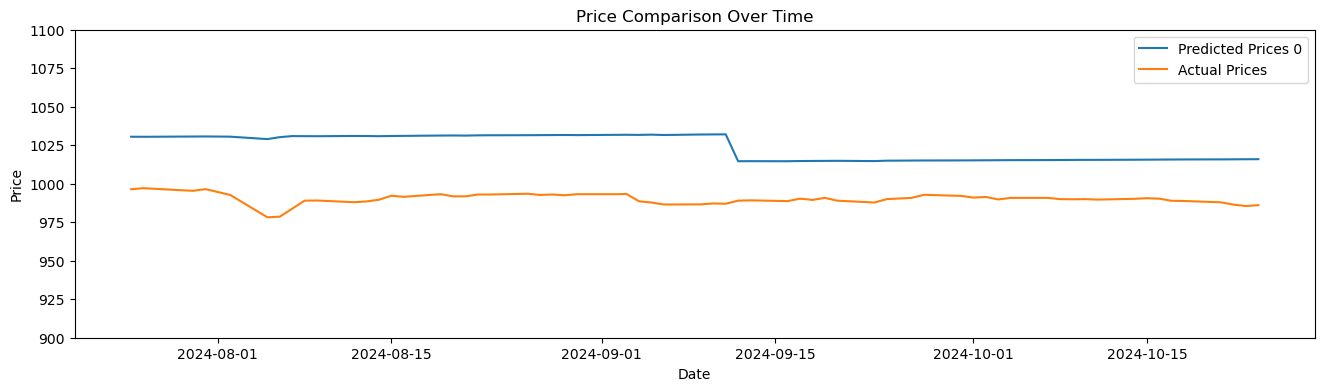

In [81]:
evaluation_plot(
    backtest_start, backtest_end, combined_df, np.array([prices]), ylim=(900, 1100)
)

In [ ]:
df.DataFrame(calibrated_result).mean()